In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use("default")
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu6a1_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [3]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,716,141,HOOP,BLUEJAY,1,0
1,1261,862,SEAGULL,MAN,1,0
2,1067,1402,PIKE,SUIT,1,0
3,146,707,BOLT,HIGHWAY,1,0
4,155,1140,BOULDER,PUDDLE,1,0
...,...,...,...,...,...,...
59995,1402,1501,SUIT,TREAT,1,9999
59996,101,473,BATTERY,DISC,1,9999
59997,345,980,COLLAR,ORANGE,1,9999
59998,407,1360,CRIB,SPY,1,9999


In [4]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session,order
0,330,CLOWN,1599,0,1,0,2
1,155,BOULDER,1140,2,1,0,1
2,707,HIGHWAY,146,4,1,0,2
3,1067,PIKE,1402,6,1,0,1
4,862,MAN,1261,8,1,0,2
...,...,...,...,...,...,...,...
59995,1360,SPY,407,2,1,9999,2
59996,980,ORANGE,345,4,1,9999,2
59997,101,BATTERY,473,6,1,9999,1
59998,1402,SUIT,1501,8,1,9999,1


### Run CMR-IA

In [5]:
s_mat = np.load('../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.45,
    beta_distract = 0.1,
    beta_rec = 0.1,
    gamma_fc = 0.2,
    gamma_cf = 0.2,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.04,
    lamb = 0.02,
    eta = 0.02,
    alpha = 0.5,
    omega = 2,
    phi_s = 1,
    phi_d = 0.75,
    nitems_in_accumulator = 12,
    d_ass = 0.8
)
params

# using parameters from simu5, the figure gives a U shape, because of U shape f_in diff, because primacy
# prob: how to flatten end? how to make initial decrease straight?
# 7.17 phi_s, phi_d could only flatten the last three
# phi_s control the base level and the last node
# phi_d control the last two

{'beta_enc': 0.5,
 'beta_rec': 0.1,
 'beta_cue': 0.45,
 'beta_rec_post': 0.5,
 'beta_distract': 0.1,
 'phi_s': 1,
 'phi_d': 0.75,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.04,
 'eta': 0.02,
 'omega': 2,
 'alpha': 0.5,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.02,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 12,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.2,
 'gamma_cf': 0.2}

In [7]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 192.74800181388855


,list,session,test_itemno,s_resp,s_rt,csim
0,1,0,330,155.0,2260.0,0.444430
1,1,0,155,1140.0,1940.0,0.550961
2,1,0,707,330.0,4000.0,0.559977
3,1,0,1067,1402.0,2850.0,0.382094
4,1,0,862,1599.0,2710.0,0.375397
...,...,...,...,...,...,...
59995,1,9999,1360,345.0,2640.0,0.334248
59996,1,9999,980,407.0,3330.0,0.429477
59997,1,9999,101,132.0,3770.0,0.514665
59998,1,9999,1402,1360.0,3510.0,0.479028


In [8]:
df_simu = df_simu.merge(df_test,on=['session','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,order,correct
0,1,0,330,155.0,2260.0,0.444430,CLOWN,1599,0,1,2,False
1,1,0,155,1140.0,1940.0,0.550961,BOULDER,1140,2,1,1,True
2,1,0,707,330.0,4000.0,0.559977,HIGHWAY,146,4,1,2,False
3,1,0,1067,1402.0,2850.0,0.382094,PIKE,1402,6,1,1,True
4,1,0,862,1599.0,2710.0,0.375397,MAN,1261,8,1,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1,9999,1360,345.0,2640.0,0.334248,SPY,407,2,1,2,False
59996,1,9999,980,407.0,3330.0,0.429477,ORANGE,345,4,1,2,False
59997,1,9999,101,132.0,3770.0,0.514665,BATTERY,473,6,1,1,False
59998,1,9999,1402,1360.0,3510.0,0.479028,SUIT,1501,8,1,1,False


In [9]:
# f_dif

In [10]:
sessions = np.unique(df_simu.session)
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    tmp_test = df_simu.loc[df_study.session == sess,"test_itemno"]
    tmp_corr = df_simu.loc[df_study.session == sess,"correct_ans"]
    testid = np.searchsorted(tmp, tmp_test)
    corrid = np.searchsorted(tmp, tmp_corr)
    
    df_simu.loc[df_simu.session == sess, 'corr_fin']= [f_dif[sess][i][id] for i, id in enumerate(corrid)]
    # df_simu.loc[df_simu.session == sess, 'omean_fin'] = [np.mean(np.delete(f_dif[sess][i], id)) for i, id in corrid]
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = [np.max(np.delete(f_dif[sess][i], id)) for i, id in enumerate(corrid)]
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,order,correct,corr_fin,omax_fin
0,1,0,330,155.0,2260.0,0.444430,CLOWN,1599,0,1,2,False,-0.474310,-0.607006
1,1,0,155,1140.0,1940.0,0.550961,BOULDER,1140,2,1,1,True,-0.517267,-0.567261
2,1,0,707,330.0,4000.0,0.559977,HIGHWAY,146,4,1,2,False,-0.597688,-0.622703
3,1,0,1067,1402.0,2850.0,0.382094,PIKE,1402,6,1,1,True,-0.650500,-0.622916
4,1,0,862,1599.0,2710.0,0.375397,MAN,1261,8,1,2,False,-0.593426,-0.650805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1,9999,1360,345.0,2640.0,0.334248,SPY,407,2,1,2,False,-0.579827,-0.698238
59996,1,9999,980,407.0,3330.0,0.429477,ORANGE,345,4,1,2,False,-2.547423,-0.627252
59997,1,9999,101,132.0,3770.0,0.514665,BATTERY,473,6,1,1,False,-0.637011,-0.780912
59998,1,9999,1402,1360.0,3510.0,0.479028,SUIT,1501,8,1,1,False,-0.658525,-0.658638


In [11]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

,lag,corr_fin,omax_fin,dif
0,0,-0.480331,-0.631552,0.151222
1,2,-0.711760,-0.677800,-0.033960
2,4,-0.741811,-0.697703,-0.044109
3,6,-0.704464,-0.690080,-0.014383
4,8,-0.664690,-0.671884,0.007194
5,10,-0.634891,-0.660114,0.025223


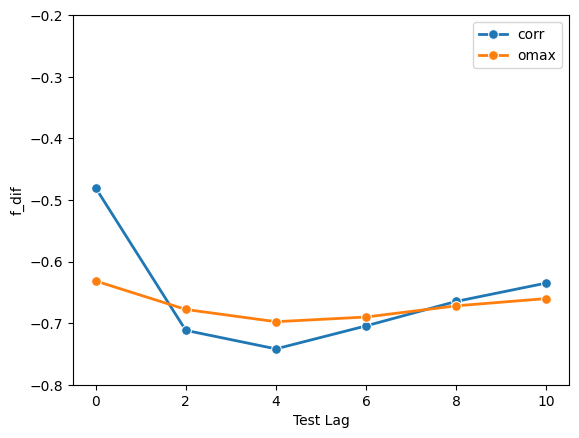

In [12]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7, label='corr')
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7, label='omax')
plt.ylim([-0.8,-0.2])
plt.xlabel('Test Lag')
plt.ylabel('f_dif')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

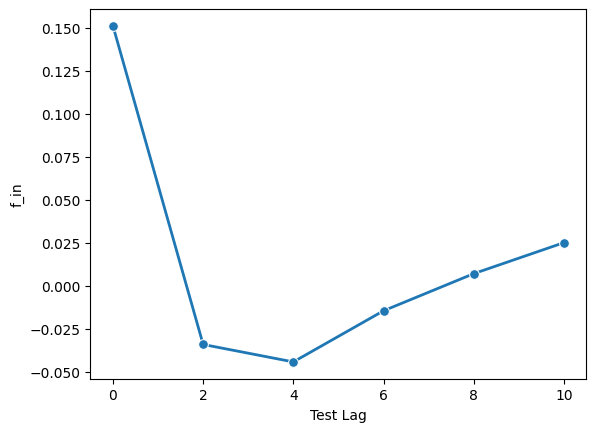

In [13]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

### PLOT

In [14]:
df_laggp = df_simu.groupby(['lag','order']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,order,corr_rate
0,0,1,0.785785
1,0,2,0.784405
2,2,1,0.642314
3,2,2,0.638090
4,4,1,0.463604
5,4,2,0.458166
6,6,1,0.362753
7,6,2,0.358103
8,8,1,0.327380
9,8,2,0.332722


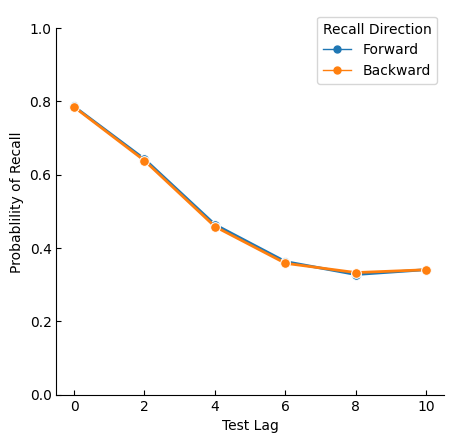

In [15]:
from matplotlib.lines import Line2D

fig,ax = plt.subplots(figsize=(5,5))
ax.spines['left'].set_bounds(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7, hue='order',palette='tab10')
plt.ylim([0,1.05])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=1, marker='o',
                          markersize = 5, linestyle='-',label = 'Forward'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=1, marker='o',
                          markersize = 5, linestyle='-', label = 'Backward')]
L = plt.legend(handles = legend_elements, title='Recall Direction',loc='upper right')
# L.get_texts()[0].set_text('Forward')
# L.get_texts()[1].set_text('Backward')
# plt.savefig('fig/simu6a_recall.pdf')
plt.show()